In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold


### XGBoost

In [2]:
train_df = pd.read_csv("X_train_features.csv")
test_df = pd.read_csv("X_test_features.csv")

In [135]:
ommit_features = set(["user_id", "merchant_id", "item_id", "cat_id", "brand_id", "label"])
features = [feature for feature in train_df.columns if feature not in ommit_features]
X = train_df[features]
y = train_df["label"]

In [136]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
import gc
del train_df
gc.collect()

0

In [3]:
params = {
    'device': 'cuda',
    "objective": "binary:logistic",
    "max_depth": 6,
    "eta": 0.01,
    "eval_metric": "auc",
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "lambda": 1,
    "alpha": 0.1,
    "seed": 42,
    "n_estimators": 2000,
    "early_stopping_rounds": 20
}

In [138]:
def train(params, X_train, y_train, X_val, y_val):
    best = None
    while True:
        print("Feature num:", len(X_train.columns))
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
        if not best:
            best = model
        else:
            if best.best_score < model.best_score:
                print("Updating best model...")
                best = model
        print(model.best_score)
        if np.any(model.feature_importances_ == 0):
            print("Redundant Features Exist, Pruning...")
            # mask = model.feature_importances_ > 0
            
            # X_train = X_train.loc[:, mask]
            # X_val = X_val.loc[:, mask]
            X_train = X_train[model.get_booster().get_fscore().keys()]
            X_val = X_val[model.get_booster().get_fscore().keys()]
            
        else:
            print("Removed", len(test_df.columns) - len(X_train.columns), "columns") 
            return best
        
            

In [139]:
model = train(params, X_train, y_train, X_val, y_val)
X_train = X_train[model.get_booster().feature_names]
X_val = X_val[model.get_booster().feature_names]

Feature num: 522
0.7000274709855514
Redundant Features Exist, Pruning...
Feature num: 485
0.6998626034737789
Redundant Features Exist, Pruning...
Feature num: 478
0.6994252564241308
Redundant Features Exist, Pruning...
Feature num: 475
0.6992211679607095
Redundant Features Exist, Pruning...
Feature num: 474
0.6978905194988959
Redundant Features Exist, Pruning...
Feature num: 472
0.6996644571909248
Redundant Features Exist, Pruning...
Feature num: 469
Updating best model...
0.700088479932613
Redundant Features Exist, Pruning...
Feature num: 468
0.6991722833659199
Removed 59 columns


In [140]:
len(model.feature_names_in_)

469

In [143]:
len(model.get_booster().get_fscore())

468

In [17]:
def generate_predictions(pred, name):
    test_submit = pd.read_csv("data_format1/test_format1.csv")
    test_submit["prob"] = pred
    test_submit.to_csv(name + ".csv", index=False)
    return test_submit

In [48]:
pred = model.predict_proba(test_df[X_train.columns])[:, 1]
generate_predictions(pred, "predictions_best_noID")

,user_id,merchant_id,prob
0,163968,4605,0.092818
1,360576,1581,0.090364
2,98688,1964,0.061357
3,98688,3645,0.044331
4,295296,3361,0.087814
...,...,...,...
261472,228479,3111,0.057876
261473,97919,2341,0.037505
261474,97919,3971,0.076629
261475,32639,3536,0.043396


In [50]:
X.to_csv("data/X.csv", index=False)
y.to_csv("data/y.csv", index=False)
X_train.to_csv("data/X_train.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)
X_val.to_csv("data/X_val.csv", index=False)
y_val.to_csv("data/y_val.csv", index=False)

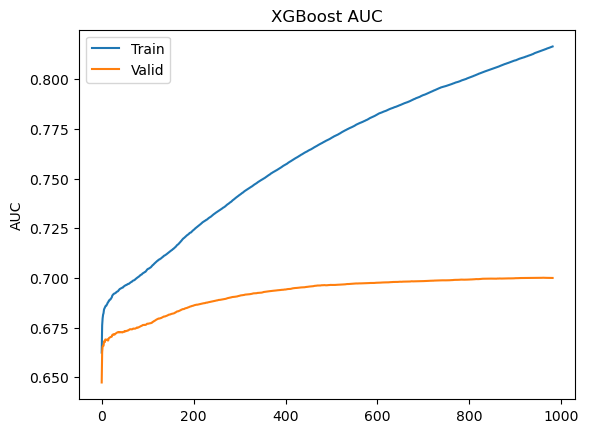

In [144]:
import matplotlib.pyplot as plt

results = model.evals_result()

epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Valid')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [118]:
feature_importance = list(zip(X_train.columns, model.feature_importances_))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

In [134]:
X_train[model.get_booster().get_fscore().keys()]

,gender,time_stamp,time_period,age_0,age_2,age_3,age_4,age_5,age_6,age_7,...,latest_one_week_carts_in_merchant_ratio_perspective,latest_one_week_favourites_in_merchant_ratio_perspective,latest_one_week_clicks_by_user_ratio_perspective,latest_one_week_carts_by_user_ratio_perspective,latest_one_week_favourites_by_user_ratio_perspective,pca_0,pca_1,pca_2,pca_3,pca_4
30846,0,184,5,True,False,False,False,False,False,False,...,0.0,0.0,0.000000,0.0,0.0,1.125885e+06,181090.353200,4.575745e+05,390060.951338,-167678.438656
159696,1,184,5,False,False,False,True,False,False,False,...,0.0,0.0,0.000000,0.0,0.0,1.113743e+06,483143.618394,4.376454e+05,469776.603951,-184731.252678
143902,1,184,5,False,False,True,False,False,False,False,...,0.0,0.0,0.000000,0.0,0.0,2.155521e+04,443136.511704,3.991954e+04,47221.360056,-76585.481763
106563,0,184,5,True,False,False,False,False,False,False,...,0.0,0.0,0.007143,0.0,0.0,3.672409e+05,-137065.311315,-9.981083e+04,189454.761988,-111322.911209
37676,0,184,5,False,False,True,False,False,False,False,...,0.0,0.0,0.000053,0.0,0.0,1.227003e+06,-597156.977998,1.047509e+06,-423680.814797,-11502.285503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213825,0,184,5,True,False,False,False,False,False,False,...,0.0,0.0,0.000080,0.0,0.0,3.679172e+05,178680.654605,2.844167e+05,87295.434619,-185297.982753
94719,0,184,5,False,False,True,False,False,False,False,...,0.0,0.0,0.002334,0.0,0.0,-9.634179e+05,-307716.849003,-1.584982e+05,-21082.376564,12999.598212
214474,1,184,5,False,False,False,True,False,False,False,...,0.0,0.0,0.000000,0.0,0.0,9.288533e+02,569987.224701,-3.559166e+04,8931.981245,-192152.620335
60946,0,184,5,False,False,False,False,False,False,True,...,0.0,0.0,0.001133,0.0,0.0,1.504699e+06,-338767.419531,-3.380683e+05,170056.413166,2176.119820


/tmp/ipykernel_51267/3873655884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=data[0:30], palette='viridis')


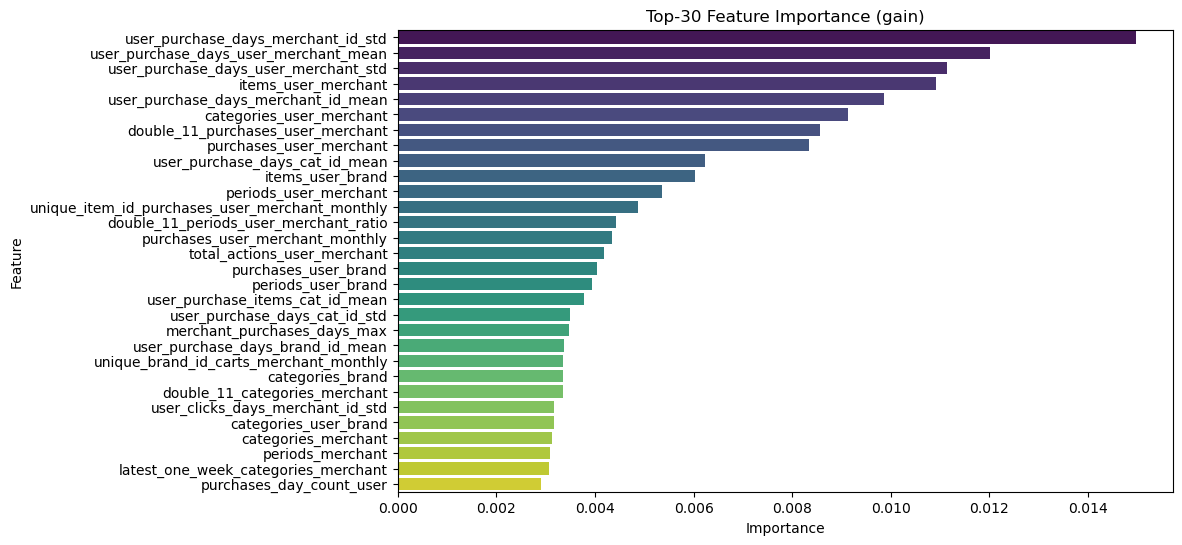

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=data[0:30], palette='viridis')
plt.title('Top-30 Feature Importance (gain)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

/tmp/ipykernel_51267/1878638282.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=data[0:30], palette='viridis')


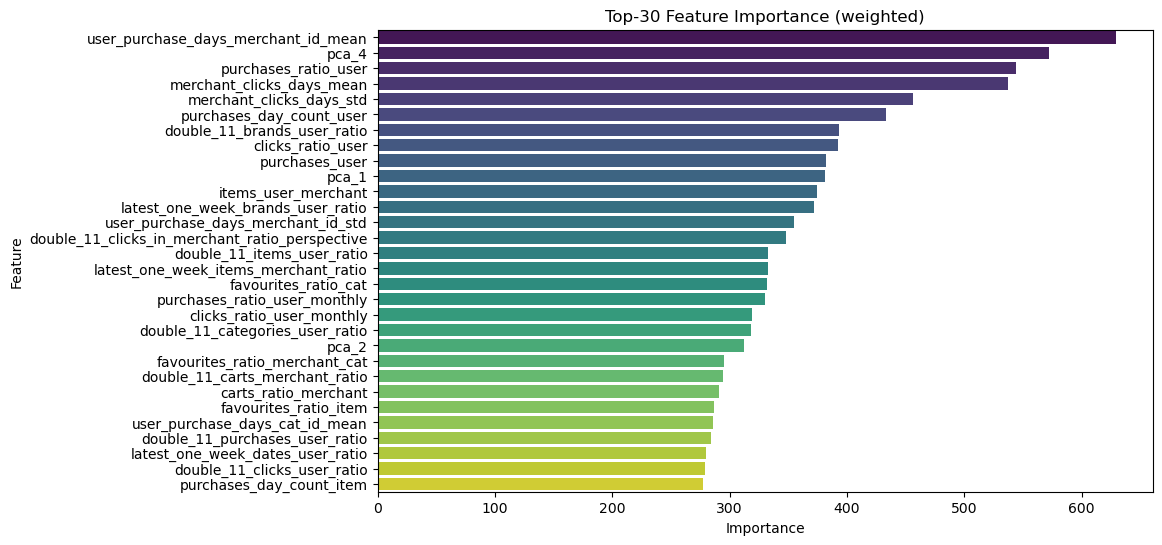

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.DataFrame(sorted(list(model.get_booster().get_score().items()), reverse=True, key=lambda x: x[1]), columns=["Feature", "Importance"])
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=data[0:30], palette='viridis')
plt.title('Top-30 Feature Importance (weighted)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [77]:
np.save("xgb_data/feature_importance.npy", feature_importance)

In [161]:
# 41 features with 0 importance
len(non_important)

38

In [53]:
model.save_model('xgb_model_best_noID.bin')

/home/franklin/miniconda3/envs/rec_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:44:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [32]:
X_f = X[model.feature_names_in_].to_numpy()
y_f = y.to_numpy()
test_filtered = test_df[model.feature_names_in_]

In [33]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store results
#oof_preds = np.zeros(len(y))  # Out-of-fold predictions for training set
test_preds = np.zeros(len(test_df))  # Average predictions for test set


for fold, (train_idx, val_idx) in enumerate(kf.split(X_f, y_f)):
    print(f"Training fold {fold + 1}...")
    
    # Split data into training and validation sets for this fold
    X_t, X_v = X_f[train_idx], X_f[val_idx]
    y_t, y_v = y_f[train_idx], y_f[val_idx]

    # Define model
    model_f = xgb.XGBClassifier(**params)
    
    # Fit model with early stopping
    model_f.fit(
        X_t, y_t,
        eval_set=[(X_t, y_t), (X_v, y_v)],
        verbose=False
    )
    print("Best AUC score:", model_f.best_score)
    # Store predictions for validation set
    #oof_preds[val_idx] = model_f.predict_proba(X_v)[:, 1]

    # Predict on the test set
    test_preds += model_f.predict_proba(test_filtered)[:, 1] / kf.n_splits

# # Final Out-of-Fold AUC Score
# from sklearn.metrics import roc_auc_score
# oof_auc = roc_auc_score(y, oof_preds)
# print(f"Out-of-Fold AUC: {oof_auc:.4f}")

Training fold 1...
Best AUC score: 0.7004955944986864


/home/franklin/miniconda3/envs/rec_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:32:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Training fold 2...
Best AUC score: 0.703241355503224
Training fold 3...
Best AUC score: 0.6933263725157142
Training fold 4...
Best AUC score: 0.7000028860876003
Training fold 5...
Best AUC score: 0.7003809441098509


In [35]:
generate_predictions(test_preds, "predictions_noID_5f")

,user_id,merchant_id,prob
0,163968,4605,0.088159
1,360576,1581,0.087818
2,98688,1964,0.068820
3,98688,3645,0.039667
4,295296,3361,0.086512
...,...,...,...
261472,228479,3111,0.065343
261473,97919,2341,0.034158
261474,97919,3971,0.065847
261475,32639,3536,0.039385


### LightGBM

In [4]:
import lightgbm as lgb

In [5]:
model_best = xgb.XGBClassifier(**params)
model_best.load_model("xgb_model_best_noID.bin")
best_features = model_best.feature_names_in_

In [7]:
len(best_features)

469

In [6]:
X = train_df[best_features]
y = train_df["label"]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'random_state': 42,
    'early_stopping': 20,
    'n_jobs': 5
}

In [11]:
model_lgb = lgb.LGBMClassifier(**params_lgb, verbosity=1)
model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])


[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 12762, number of negative: 195929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.731345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72251
[LightGBM] [Info] Number of data points in the train set: 208691, number of used features: 469
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambd

LGBMClassifier(colsample_bytree=0.8, early_stopping=20, lambda_l1=0.1,
               lambda_l2=0.1, learning_rate=0.01, max_depth=10, metric='auc',
               n_estimators=1000, n_jobs=5, objective='binary', random_state=42,
               subsample=0.8, verbosity=1)

In [11]:
X_f = X[best_features].to_numpy()
y_f = y.to_numpy()
test_filtered = test_df[best_features]

In [12]:
import gc
del train_df
del test_df
gc.collect()

0

In [ ]:
model_lgb.predict_proba(test_filtered)[:, 1]

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


array([0.08836247, 0.08770555, 0.06369083, ..., 0.08241159, 0.02961872,
       0.08406551])

In [15]:
X_f.shape

(260864, 469)

In [24]:
X_f

array([[0, 183, 5, ..., -249095.92130497363, -103976.16264054642,
        -177940.1956191225],
       [0, 183, 5, ..., 171313.924273613, -84498.92822429817,
        -178069.23658740474],
       [0, 183, 5, ..., 385254.0019542892, -92659.68838287056,
        -177340.52956579957],
       ...,
       [1, 184, 5, ..., -28994.326399592886, 105310.83950207802,
        83041.99070120449],
       [1, 184, 5, ..., -123925.73895936352, 54776.899740172536,
        82503.56996861586],
       [2, 184, 5, ..., -298080.7073881987, 159252.49067984012,
        17898.63647392206]], dtype=object)

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

# Initialize arrays to store results
#oof_preds = np.zeros(len(y))  # Out-of-fold predictions for training set
test_preds_lgb = np.zeros(len(test_filtered))  # Average predictions for test set


for fold, (train_idx, val_idx) in enumerate(kf.split(X_f, y_f)):
    print(f"Training fold {fold + 1}...")
    
    # Split data into training and validation sets for this fold
    X_t, X_v = X_f[train_idx], X_f[val_idx]
    y_t, y_v = y_f[train_idx], y_f[val_idx]
    
    model_lgb = lgb.LGBMClassifier(**params_lgb, verbosity=-1)
    model_lgb.fit(X_t, y_t, eval_set=[(X_v, y_v)])
    
    print("Best AUC score:", model_lgb.best_score_['valid_0']["auc"])

    test_preds_lgb += model_lgb.predict_proba(test_filtered)[:, 1] / kf.n_splits


Training fold 1...
Best AUC score: 0.692593905492258
Training fold 2...
Best AUC score: 0.6954179164071829
Training fold 3...
Best AUC score: 0.6996060346473058
Training fold 4...
Best AUC score: 0.6860473793601628
Training fold 5...
Best AUC score: 0.6967010656720036


In [18]:
generate_predictions(test_preds_lgb, "predictions_lgb_2")

,user_id,merchant_id,prob
0,163968,4605,0.077166
1,360576,1581,0.085806
2,98688,1964,0.065491
3,98688,3645,0.035840
4,295296,3361,0.080597
...,...,...,...
261472,228479,3111,0.068412
261473,97919,2341,0.037348
261474,97919,3971,0.071123
261475,32639,3536,0.037616


In [163]:
model_lgb._evals_result

{'valid_0': OrderedDict([('auc',
               [0.6487002719963557,
                0.6573174225822189,
                0.6611409645864598,
                0.664029241928154,
                0.6641639825524523,
                0.6635009638364074,
                0.6639063408666445,
                0.6632835926634901,
                0.6643882846694237,
                0.6651599297741133,
                0.665271346459718,
                0.6656123834659033,
                0.666047765788105,
                0.6660735920343933,
                0.66641119556737,
                0.6661414135298812,
                0.6660905354087084,
                0.6669632903796129,
                0.6671225612980564,
                0.6671381351229462,
                0.6672699670546566,
                0.6672342179747986,
                0.6674613807861304,
                0.6673945544538932,
                0.667682287828475,
                0.6676039259222235,
                0.6679053451914128,
 

In [150]:
model_lgb.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.8036890094712219),
                          ('binary_logloss', 0.1956876180025571)]),
             'valid_1': OrderedDict([('auc', 0.6972284287485832),
                          ('binary_logloss', 0.21459705483329425)])})

LGBMClassifier(alpha=0.1, colsample_bytree=0.6, device='cuda',
               early_stopping_rounds=20, eta=0.01, eval_metric='auc', lambda=1,
               max_depth=6, n_estimators=2000, objective='binary:logistic',
               seed=42, subsample=0.8)

### Prepare Datasets for ReChorus